# Facebook Live Data Analysis with K-Means Clustering 
# With Proper Cluster Evaluation Metrics and Visualizations

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore')

# =============================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================

In [ ]:
# Load the data
df = pd.read_csv('/kaggle/input/facebook-live-sellers-in-thailand-uci-ml-repo/Live.csv')

# Data cleaning


In [188]:
print("Initial data shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

Initial data shape: (7050, 16)

Missing values:
 status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64


In [189]:
# Drop empty columns
df = df.drop(['Column1', 'Column2', 'Column3', 'Column4'], axis=1)


In [190]:
# Convert status_published to datetime and extract features
df['status_published'] = pd.to_datetime(df['status_published'])
df['year'] = df['status_published'].dt.year
df['month'] = df['status_published'].dt.month
df['day'] = df['status_published'].dt.day
df['hour'] = df['status_published'].dt.hour
df['day_of_week'] = df['status_published'].dt.dayofweek
# Calculate total reactions and engagement
reaction_cols = ['num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
df['total_reactions'] = df[reaction_cols].sum(axis=1)
df['engagement'] = df['total_reactions'] + df['num_comments'] + df['num_shares']

In [191]:
# Drop original date column
df = df.drop('status_published', axis=1)

In [192]:
print("\nAfter cleaning, data shape:", df.shape)
print("\nSample of cleaned data:")
print(df.head())


After cleaning, data shape: (7050, 18)

Sample of cleaned data:
                          status_id status_type  num_reactions  num_comments  \
0  246675545449582_1649696485147474       video            529           512   
1  246675545449582_1649426988507757       photo            150             0   
2  246675545449582_1648730588577397       video            227           236   
3  246675545449582_1648576705259452       photo            111             0   
4  246675545449582_1645700502213739       photo            213             0   

   num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0         262        432         92         3          1         1   
1           0        150          0         0          0         0   
2          57        204         21         1          1         0   
3           0        111          0         0          0         0   
4           0        204          9         0          0         0   

   num_angrys  year  month  day  

# =============================================
# 2. EXPLORATORY DATA ANALYSIS & VISUALIZATION
# =============================================

Text(0, 0.5, 'Count')

<Figure size 1500x1000 with 0 Axes>

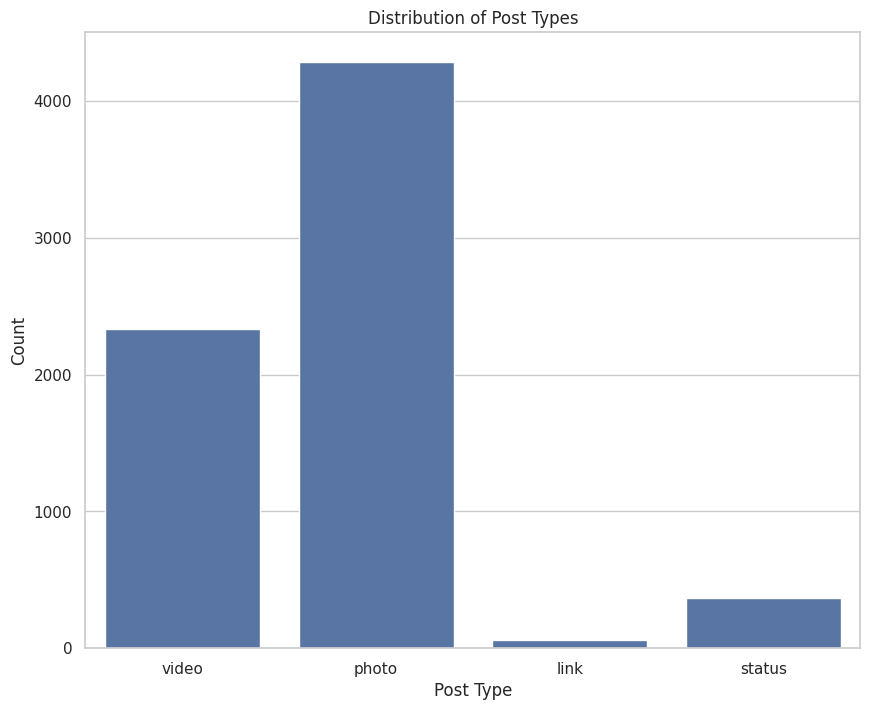

In [193]:
# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
# 1. Distribution of post types
plt.figure(figsize=(10, 8))
sns.countplot(x='status_type', data=df)
plt.title('Distribution of Post Types')
plt.xlabel('Post Type')
plt.ylabel('Count')

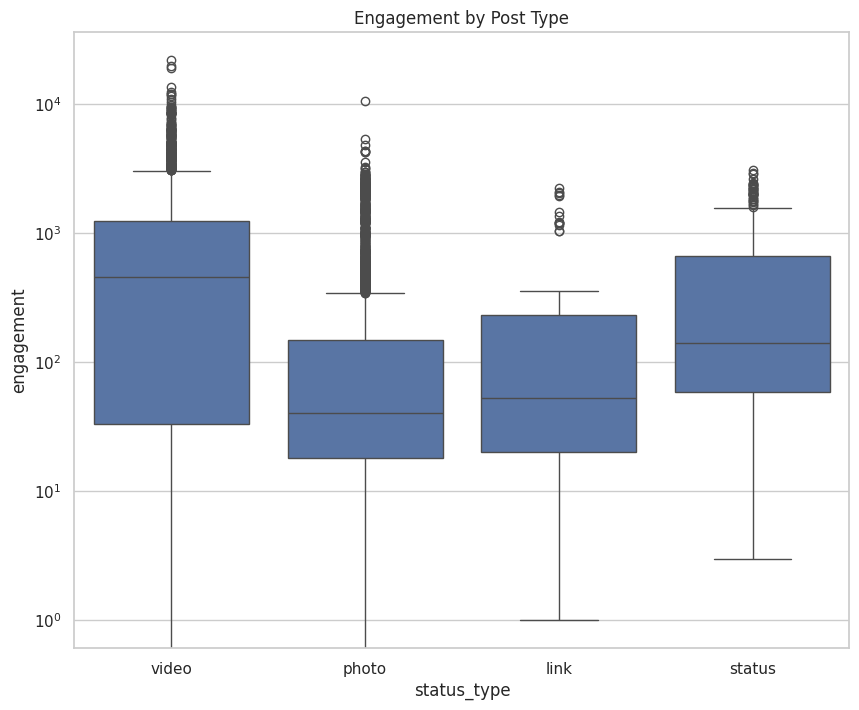

In [194]:
# 2. Engagement by post type
plt.figure(figsize=(10, 8))
sns.boxplot(x='status_type', y='engagement', data=df)
plt.title('Engagement by Post Type')
plt.yscale('log')

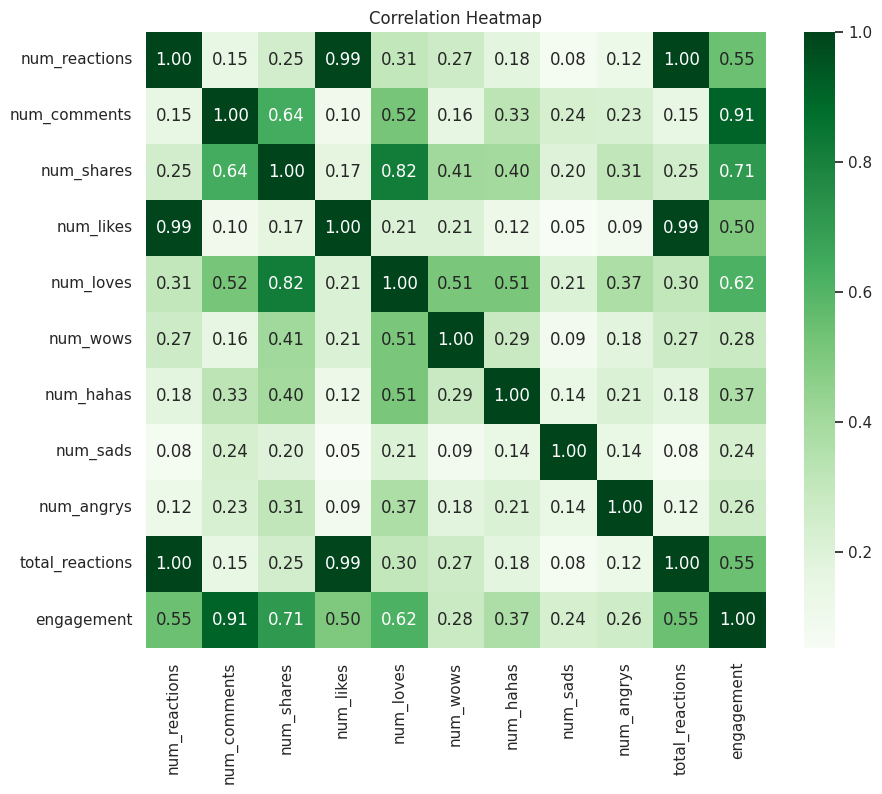

In [195]:
# 3. Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = ['num_reactions', 'num_comments', 'num_shares'] + reaction_cols + ['total_reactions', 'engagement']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='Greens', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


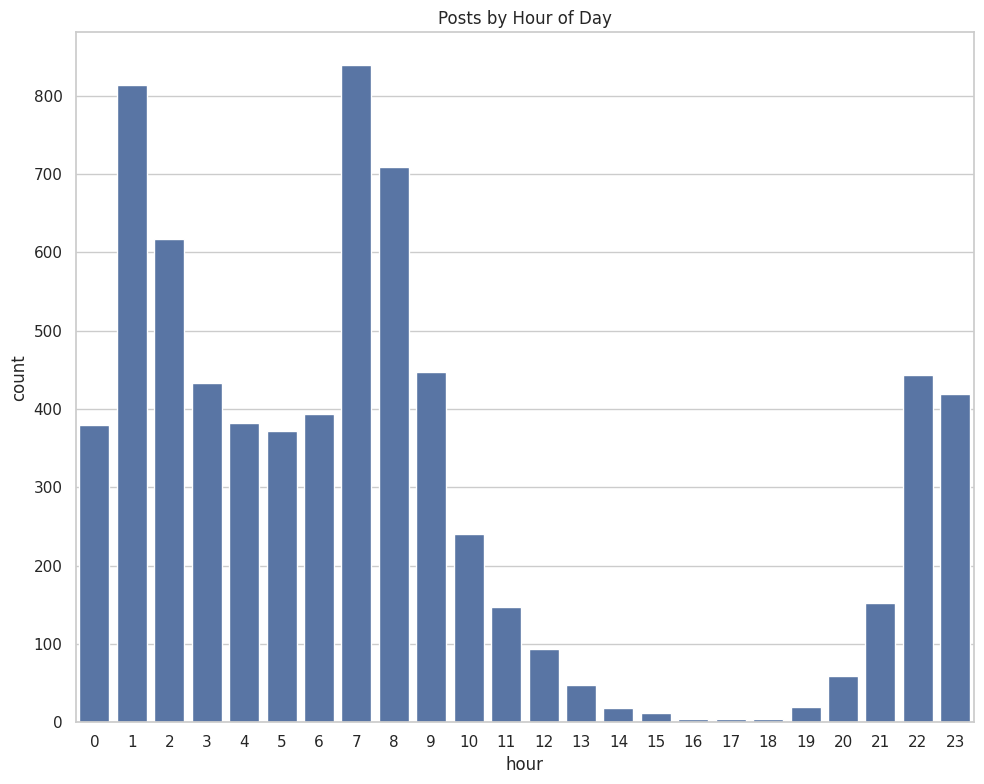

In [196]:
# 4. Temporal patterns - posts by hour
plt.figure(figsize=(10, 8))
sns.countplot(x='hour', data=df)
plt.title('Posts by Hour of Day')
plt.tight_layout()
plt.show()

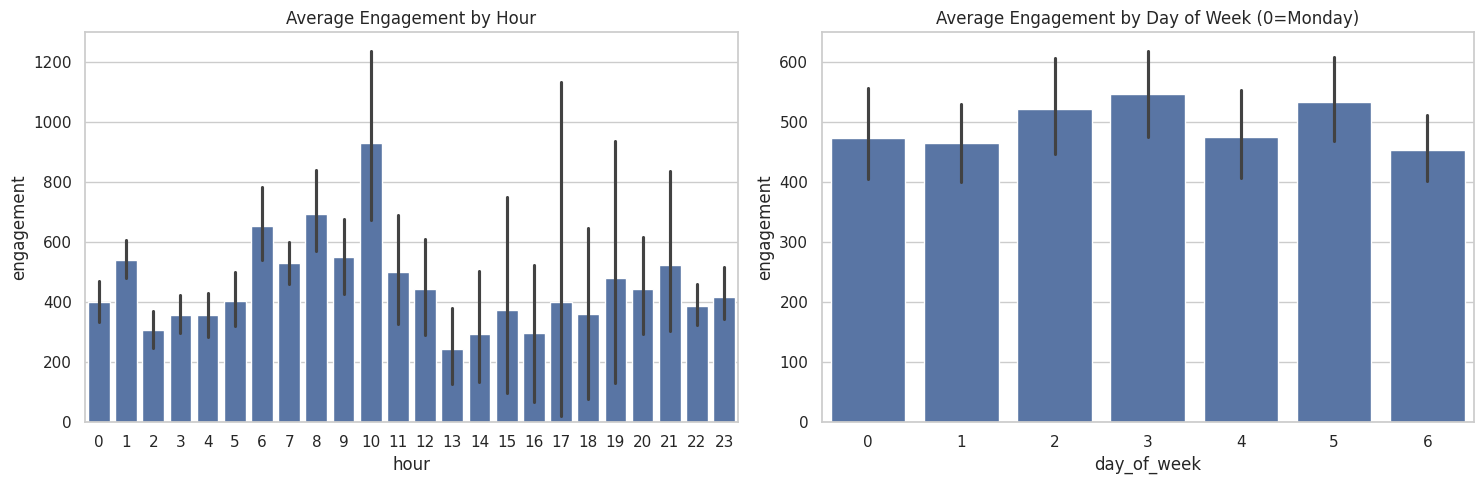

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Engagement by hour
sns.barplot(x='hour', y='engagement', data=df, ax=axes[0])
axes[0].set_title('Average Engagement by Hour')

# Engagement by day of week
sns.barplot(x='day_of_week', y='engagement', data=df, ax=axes[1])
axes[1].set_title('Average Engagement by Day of Week (0=Monday)')

plt.tight_layout()
plt.show()


# =============================================
# 3. K-MEANS CLUSTERING IMPLEMENTATION
# =============================================

In [198]:
class KMeansClustering:
    def __init__(self, k=3, max_iterations=100):
        self.k = k
        self.max_iterations = max_iterations
        
    def initialize_centroids(self, X):
        # Random initialization with fixed seed for reproducibility
        np.random.seed(42)
        random_indices = np.random.permutation(X.shape[0])
        centroids = X[random_indices[:self.k]]
        return centroids
    
    def compute_distance(self, X, centroids):
        distances = np.zeros((X.shape[0], self.k))
        for k in range(self.k):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        return distances
    
    def find_closest_cluster(self, distances):
        return np.argmin(distances, axis=1)
    
    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.k, X.shape[1]))
        for k in range(self.k):
            centroids[k] = np.mean(X[labels == k], axis=0)
        return centroids
    
    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        
        for i in range(self.max_iterations):
            old_centroids = self.centroids
            
            distances = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distances)
            self.centroids = self.compute_centroids(X, self.labels)
            
            # Check for convergence
            if np.all(old_centroids == self.centroids):
                break
                
        return self
    
    def predict(self, X):
        distances = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distances)

# =============================================
# 4. APPLYING K-MEANS TO OUR DATA
# =============================================

# Select features for clustering

In [199]:
features = reaction_cols + ['num_comments', 'num_shares']
X = df[features]
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# Elbow method to determine optimal k


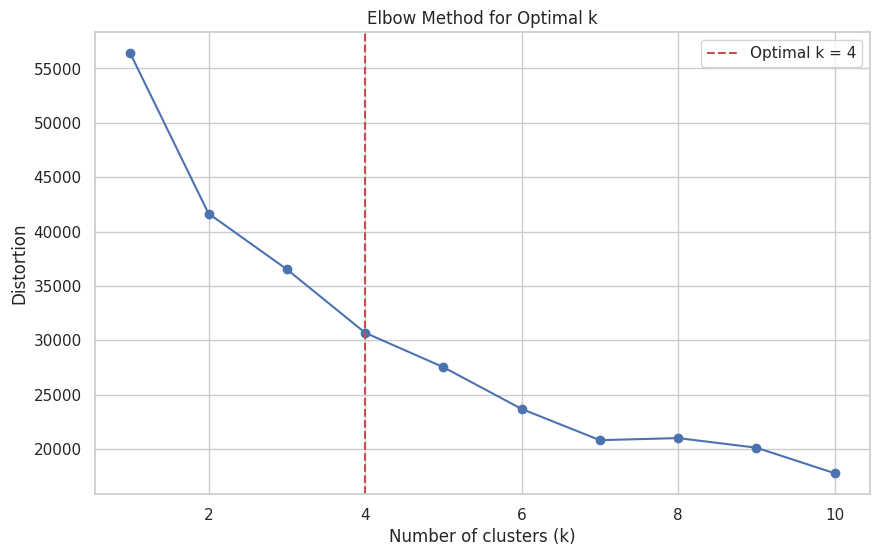

In [200]:
def plot_elbow_method(X, max_k=10):
    distortions = []
    for k in range(1, max_k+1):
        kmeans = KMeansClustering(k=k)
        kmeans.fit(X)
        # Calculate distortion (sum of squared distances to centroids)
        distortion = 0
        for i in range(X.shape[0]):
            centroid = kmeans.centroids[kmeans.labels[i]]
            distortion += np.sum((X[i] - centroid) ** 2)
        distortions.append(distortion)
        
    kneedle = KneeLocator(range(1, max_k+1), distortions, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k+1), distortions, marker='o')
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.legend(loc='upper right')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.show()
plot_elbow_method(X_scaled)

kmeans = KMeansClustering(k=3)
kmeans.fit(X_scaled)
df['cluster'] = kmeans.labels


# =============================================
# 5. CLUSTER EVALUATION AND VISUALIZATION 
# =============================================

In [201]:
cluster_centers_original = scaler.inverse_transform(kmeans.centroids)
cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=features)
print("\nCluster Centers (Original Scale):")
print(cluster_centers_df)



Cluster Centers (Original Scale):
     num_likes   num_loves   num_wows  num_hahas  num_sads  num_angrys  \
0   102.672159    7.358914   0.537822   0.338198  0.142185    0.052260   
1   583.290210  145.555944  16.416084   9.374126  2.797203    1.618881   
2  1772.974490    3.104592   2.469388   0.188776  0.030612    0.005102   

   num_comments  num_shares  
0    101.991525   21.288606  
1   3177.209790  496.881119  
2     59.025510   11.224490  


# Calculate Metrics


In [202]:
silhouette_avg = silhouette_score(X_scaled, df['cluster'])
davies_bouldin = davies_bouldin_score(X_scaled, df['cluster'])
calinski_harabasz = calinski_harabasz_score(X_scaled, df['cluster'])
inertia = 0
for i in range(len(X_scaled)):
    centroid = kmeans.centroids[df['cluster'][i]]
    inertia += np.sum((X_scaled[i] - centroid) ** 2)

print("\n" + "="*60)
print("CLUSTERING PERFORMANCE METRICS")
print("="*60)
print(f"{'Silhouette Score:':<25} {silhouette_avg:.3f} (Higher is better, range [-1, 1])")
print(f"{'Davies-Bouldin Index:':<25} {davies_bouldin:.3f} (Lower is better)")
print(f"{'Calinski-Harabasz Index:':<25} {calinski_harabasz:.3f} (Higher is better)")
print(f"{'Inertia:':<25} {inertia:.2f} (Lower is better)")
print("="*60 + "\n")


CLUSTERING PERFORMANCE METRICS
Silhouette Score:         0.709 (Higher is better, range [-1, 1])
Davies-Bouldin Index:     1.101 (Lower is better)
Calinski-Harabasz Index:  1916.820 (Higher is better)
Inertia:                  36528.25 (Lower is better)



In [203]:
# Analyze cluster centers and Create cluster labels
cluster_centers_original = scaler.inverse_transform(kmeans.centroids)
cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=features)
engagement_means = cluster_centers_df.mean(axis=1)
cluster_order = engagement_means.argsort()
cluster_labels = {cluster_order[0]: "Low Engagement",
                 cluster_order[1]: "Medium Engagement",
                 cluster_order[2]: "High Engagement"}
df['cluster_label'] = df['cluster'].map(cluster_labels)

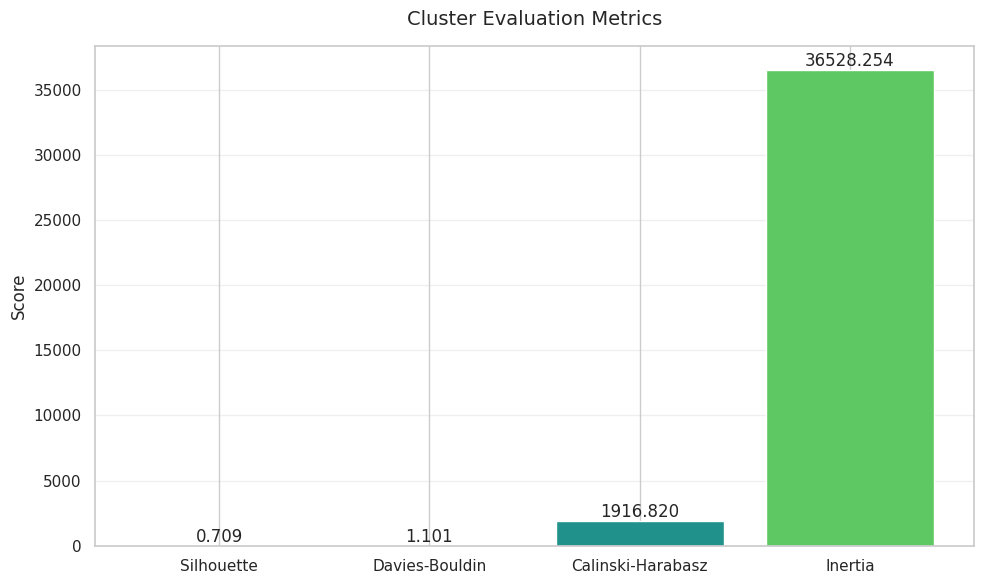

In [204]:
def plot_cluster_metrics(silhouette_avg, davies_bouldin, calinski_harabasz, inertia):
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'Inertia']
    values = [silhouette_avg, davies_bouldin, calinski_harabasz, inertia]
    colors = ['#440154', '#3b528b', '#21918c', '#5ec962']
    
    bars = ax.bar(metrics, values, color=colors)
    ax.set_title('Cluster Evaluation Metrics', fontsize=14, pad=15)
    ax.set_ylabel('Score', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
plot_cluster_metrics(silhouette_avg, davies_bouldin, calinski_harabasz, inertia)


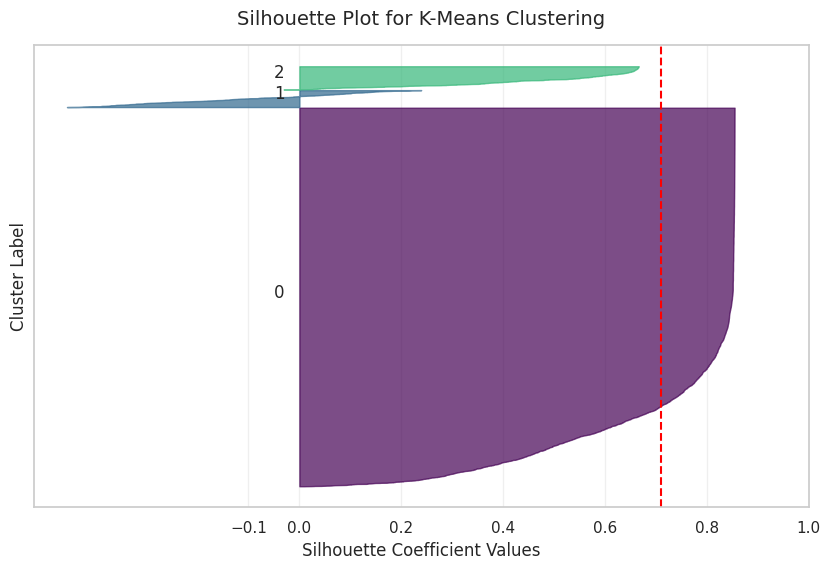

In [205]:
def plot_silhouette(X_scaled, labels):
    plt.figure(figsize=(10, 6))
    sample_silhouette_values = silhouette_samples(X_scaled, labels)
    y_lower = 10
    
    for i in range(3):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.viridis(float(i) / 3)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)
        y_lower = y_upper + 10
    
    plt.title("Silhouette Plot for K-Means Clustering", fontsize=14, pad=15)
    plt.xlabel("Silhouette Coefficient Values", fontsize=12)
    plt.ylabel("Cluster Label", fontsize=12)
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.grid(alpha=0.3)
    plt.show()
plot_silhouette(X_scaled, df['cluster'])


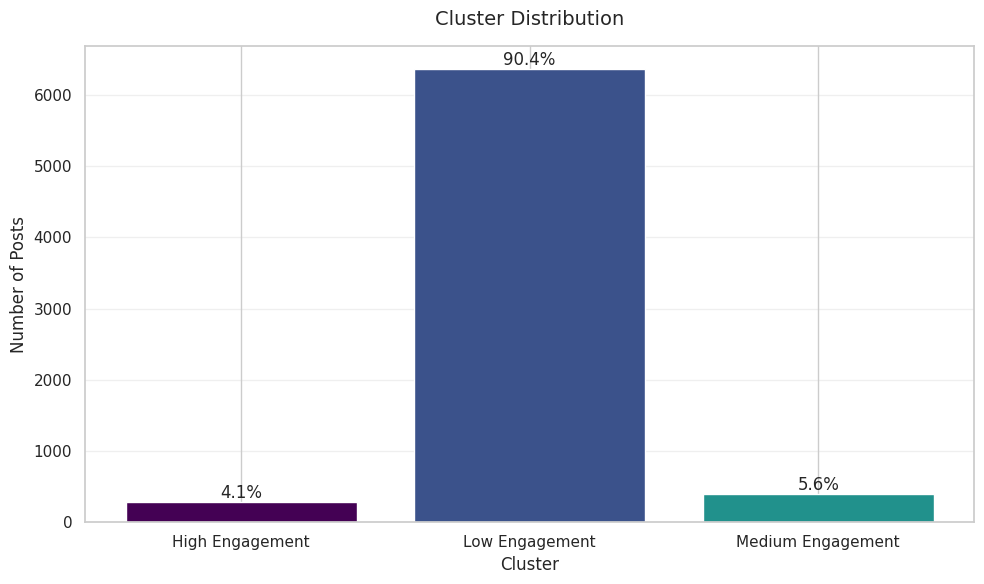

In [206]:
def plot_cluster_distribution(df):
    plt.figure(figsize=(10, 6))
    cluster_counts = df['cluster_label'].value_counts().sort_index()
    colors = ['#440154', '#3b528b', '#21918c']
    bars = plt.bar(cluster_counts.index, cluster_counts, color=colors)
    plt.title('Cluster Distribution', fontsize=14, pad=15)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Number of Posts', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    total = len(df)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height/total:.1%}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
plot_cluster_distribution(df)

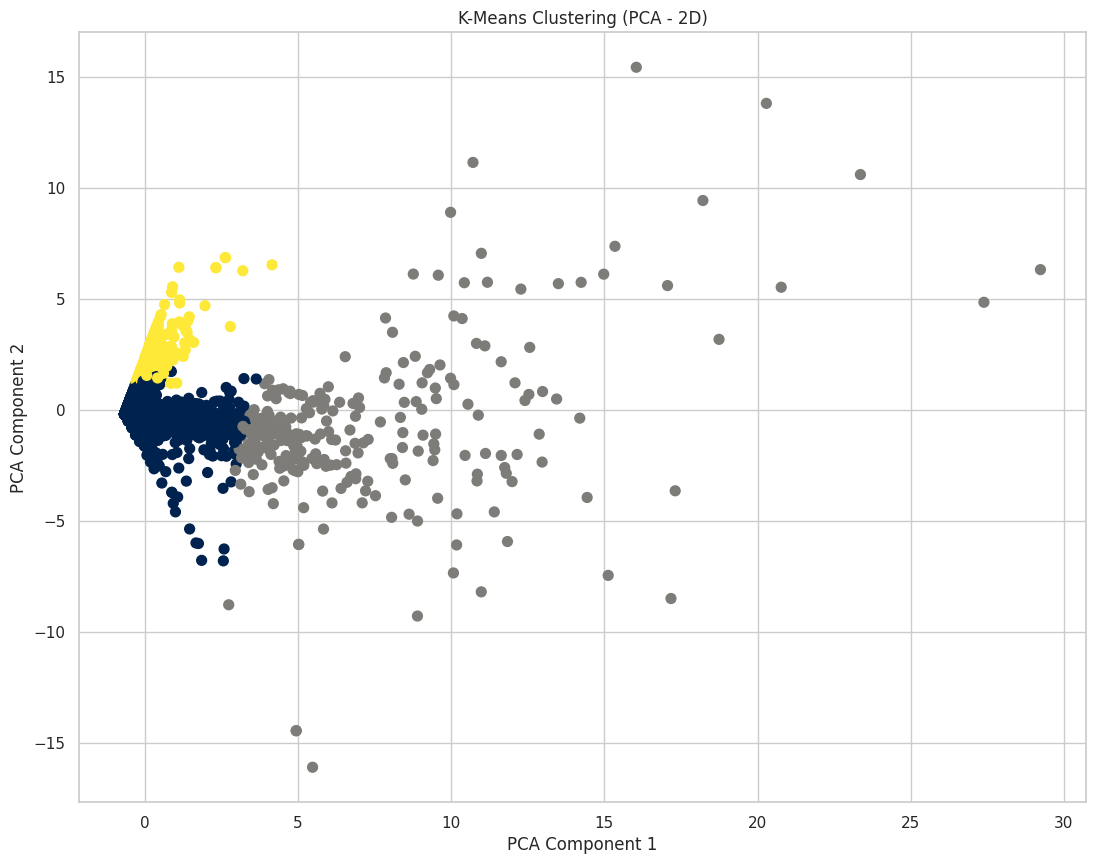

In [216]:

# PCA transformation for 2D visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# 2D PCA visualization
plt.figure(figsize=(13, 10))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans.labels, cmap='cividis', s=50)
plt.title('K-Means Clustering (PCA - 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


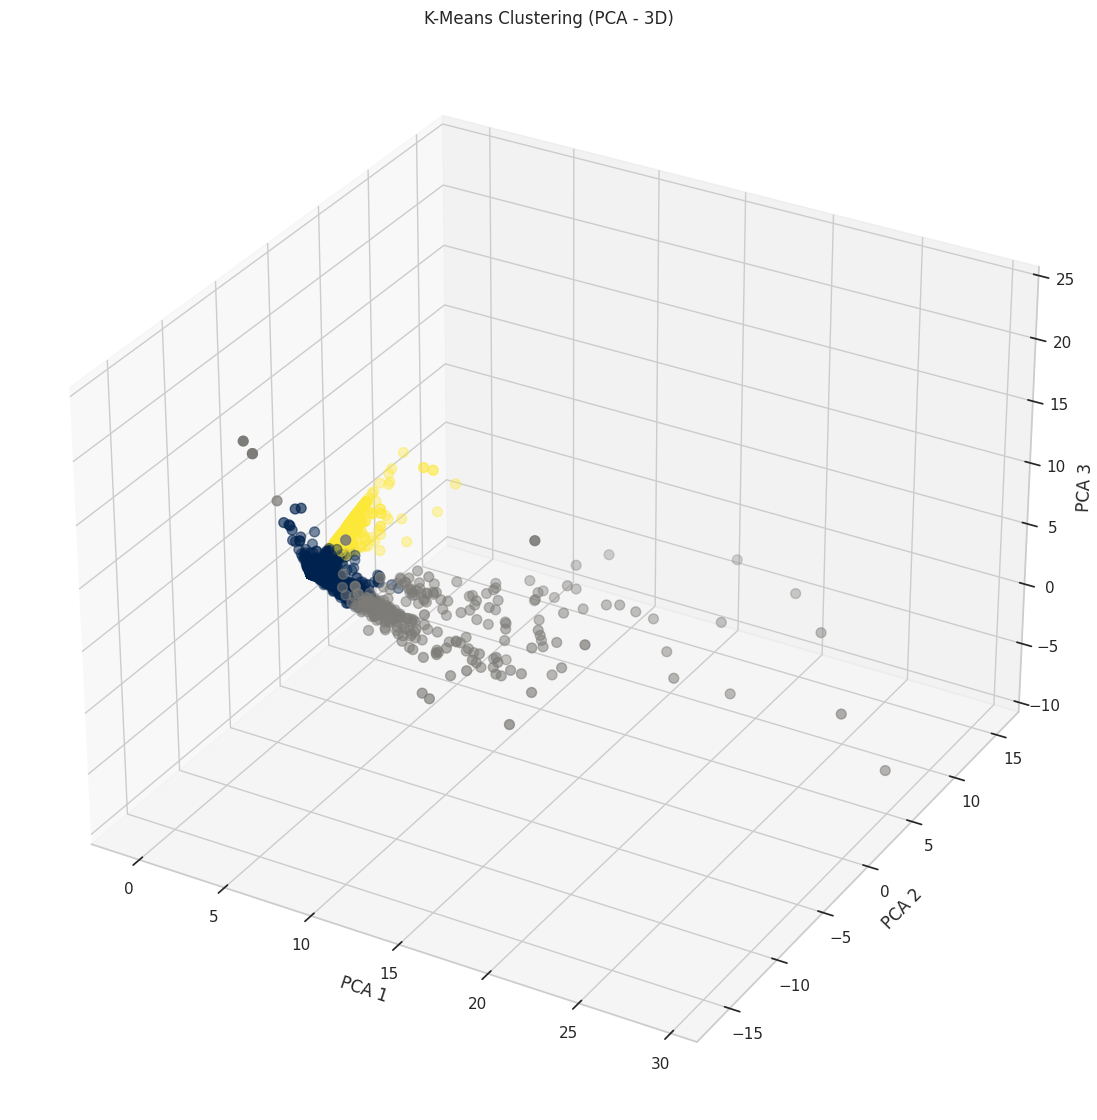

In [215]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# 3D PCA visualization
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=kmeans.labels, cmap='cividis', s=50)
ax.set_title("K-Means Clustering (PCA - 3D)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.show()



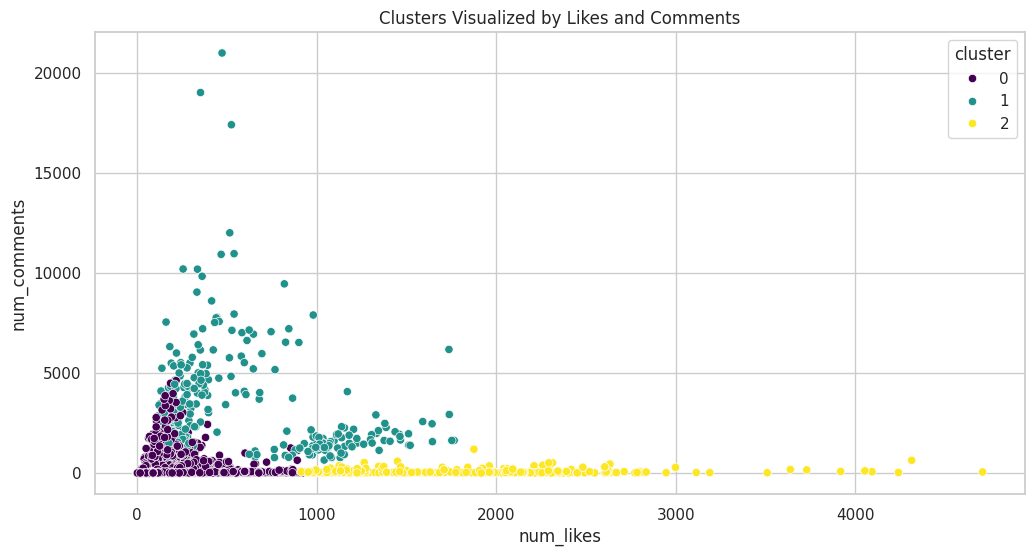

In [208]:
# 2D visualization of clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='num_likes', y='num_comments', hue='cluster', data=df, palette='viridis')
plt.title('Clusters Visualized by Likes and Comments')
plt.show()


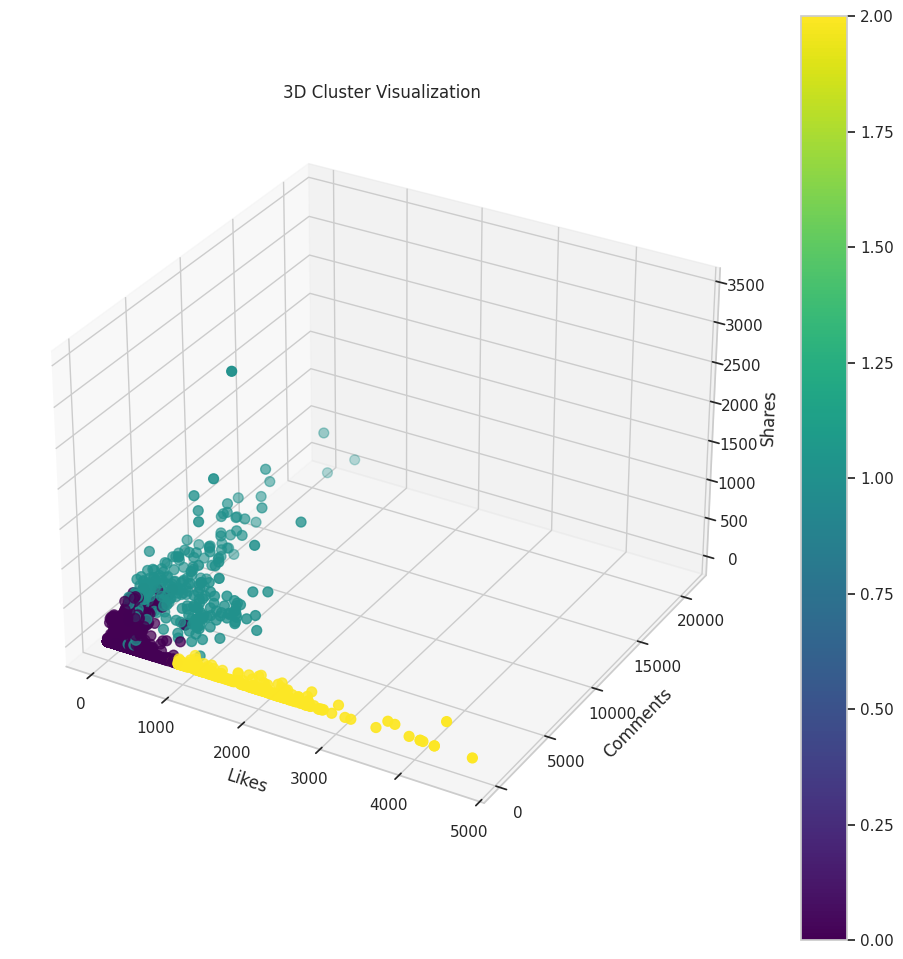

In [209]:
# 3D visualization of clusters
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['num_likes'], df['num_comments'], df['num_shares'], 
                     c=df['cluster'], cmap='viridis', s=50)

ax.set_xlabel('Likes')
ax.set_ylabel('Comments')
ax.set_zlabel('Shares')
ax.set_title('3D Cluster Visualization')
plt.colorbar(scatter)
plt.show()

# =============================================
# 6. CLUSTER INTERPRETATION AND ANALYSIS
# =============================================

In [210]:
engagement_means = cluster_centers_df.mean(axis=1)
cluster_order = engagement_means.argsort()
cluster_labels = {cluster_order[0]: "Low Engagement",
                 cluster_order[1]: "Medium Engagement",
                 cluster_order[2]: "High Engagement"}
df['cluster_label'] = df['cluster'].map(cluster_labels)
engagement_stats = df.groupby('cluster_label')['engagement'].describe()
print("\nEngagement Statistics by Cluster:")
print(engagement_stats)


Engagement Statistics by Cluster:
                    count         mean          std    min      25%     50%  \
cluster_label                                                                 
High Engagement     286.0  4433.143357  2880.249783  128.0  2699.25  3818.0   
Low Engagement     6372.0   234.381670   437.107567    0.0    18.00    51.0   
Medium Engagement   392.0  1849.022959   695.029578  951.0  1278.50  1823.0   

                       75%      max  
cluster_label                        
High Engagement    5409.75  21708.0  
Low Engagement      238.00   5078.0  
Medium Engagement  2234.75   5300.0  


# ===============================================
# 7. ADDITIONAL VISUALIZATIONS (Comparisons By Cluster)
# ===============================================

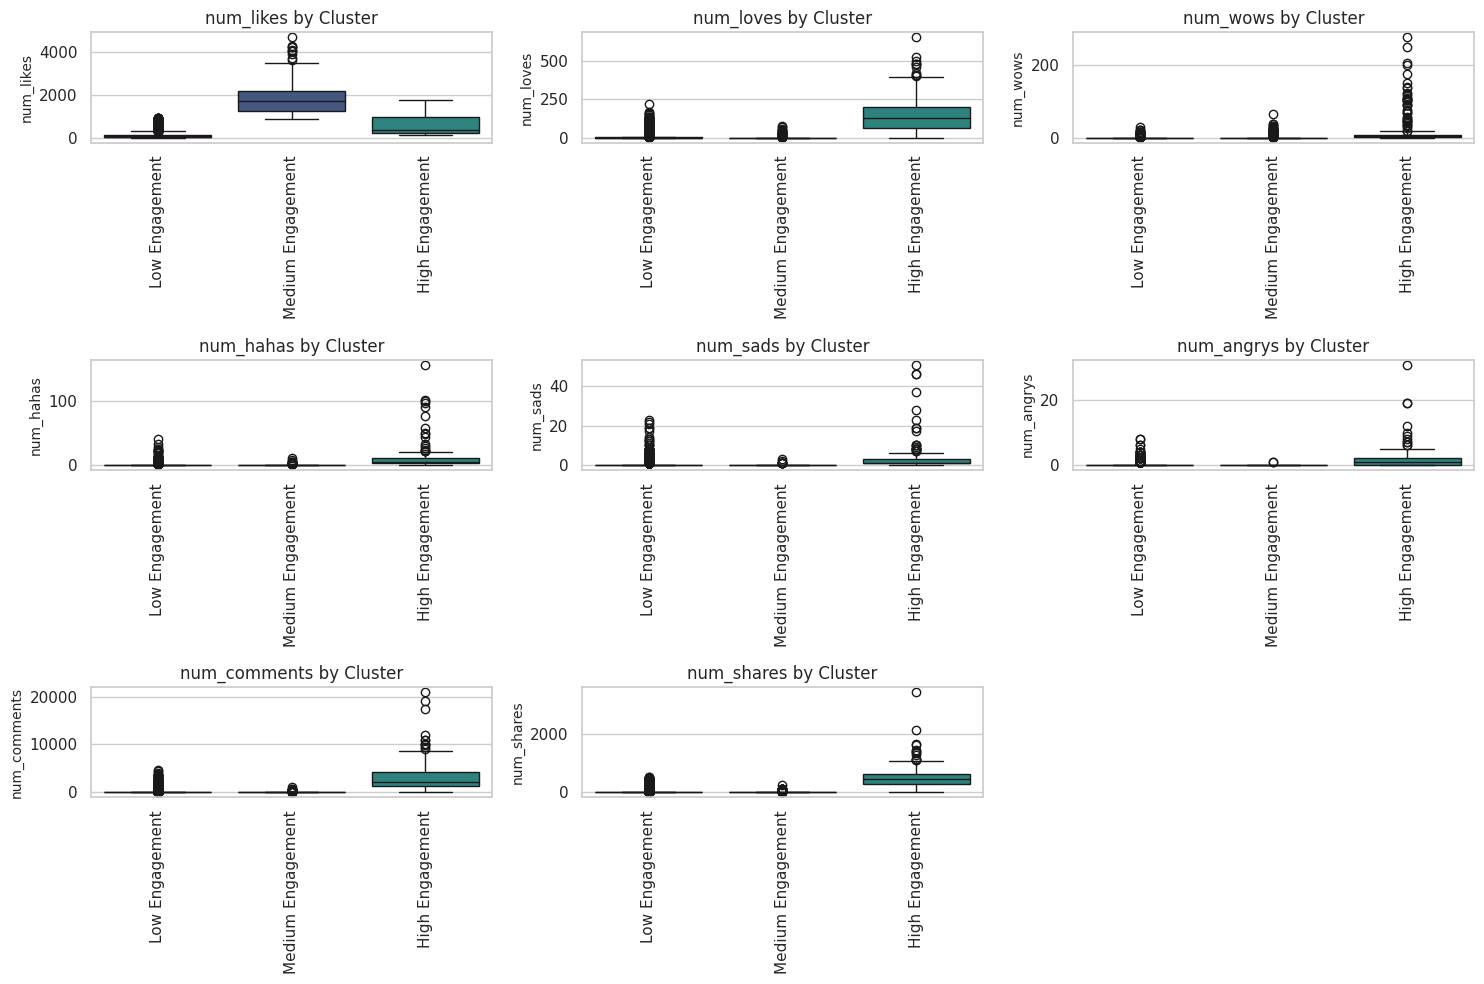

In [211]:
def plot_cluster_features_enhanced(df, features, cluster_col='cluster_label'):
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i+1)
        sns.boxplot(x=cluster_col, y=feature, data=df, 
                   order=["Low Engagement", "Medium Engagement", "High Engagement"],
                   palette=['#440154', '#3b528b', '#21918c'])
        plt.title(f'{feature} by Cluster', fontsize=12)
        plt.xlabel('')
        plt.ylabel(feature, fontsize=10)
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
plot_cluster_features_enhanced(df, features)


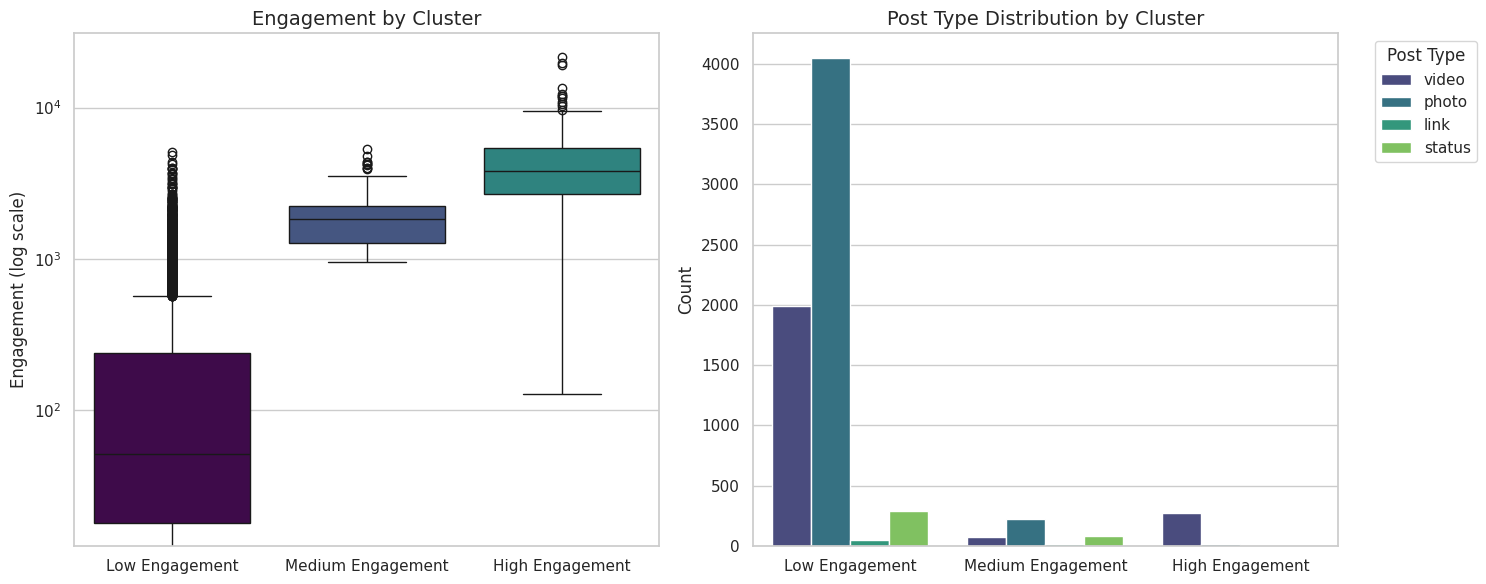

In [212]:
def plot_engagement_comparison(df):
    """Enhanced engagement comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Engagement by cluster
    sns.boxplot(x='cluster_label', y='engagement', data=df, 
               order=["Low Engagement", "Medium Engagement", "High Engagement"],
               palette=['#440154', '#3b528b', '#21918c'], ax=axes[0])
    axes[0].set_title('Engagement by Cluster', fontsize=14)
    axes[0].set_yscale('log')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Engagement (log scale)', fontsize=12)
    
    # Post type distribution
    sns.countplot(x='cluster_label', hue='status_type', data=df,
                 order=["Low Engagement", "Medium Engagement", "High Engagement"],
                 palette='viridis', ax=axes[1])
    axes[1].set_title('Post Type Distribution by Cluster', fontsize=14)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].legend(title='Post Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
plot_engagement_comparison(df)

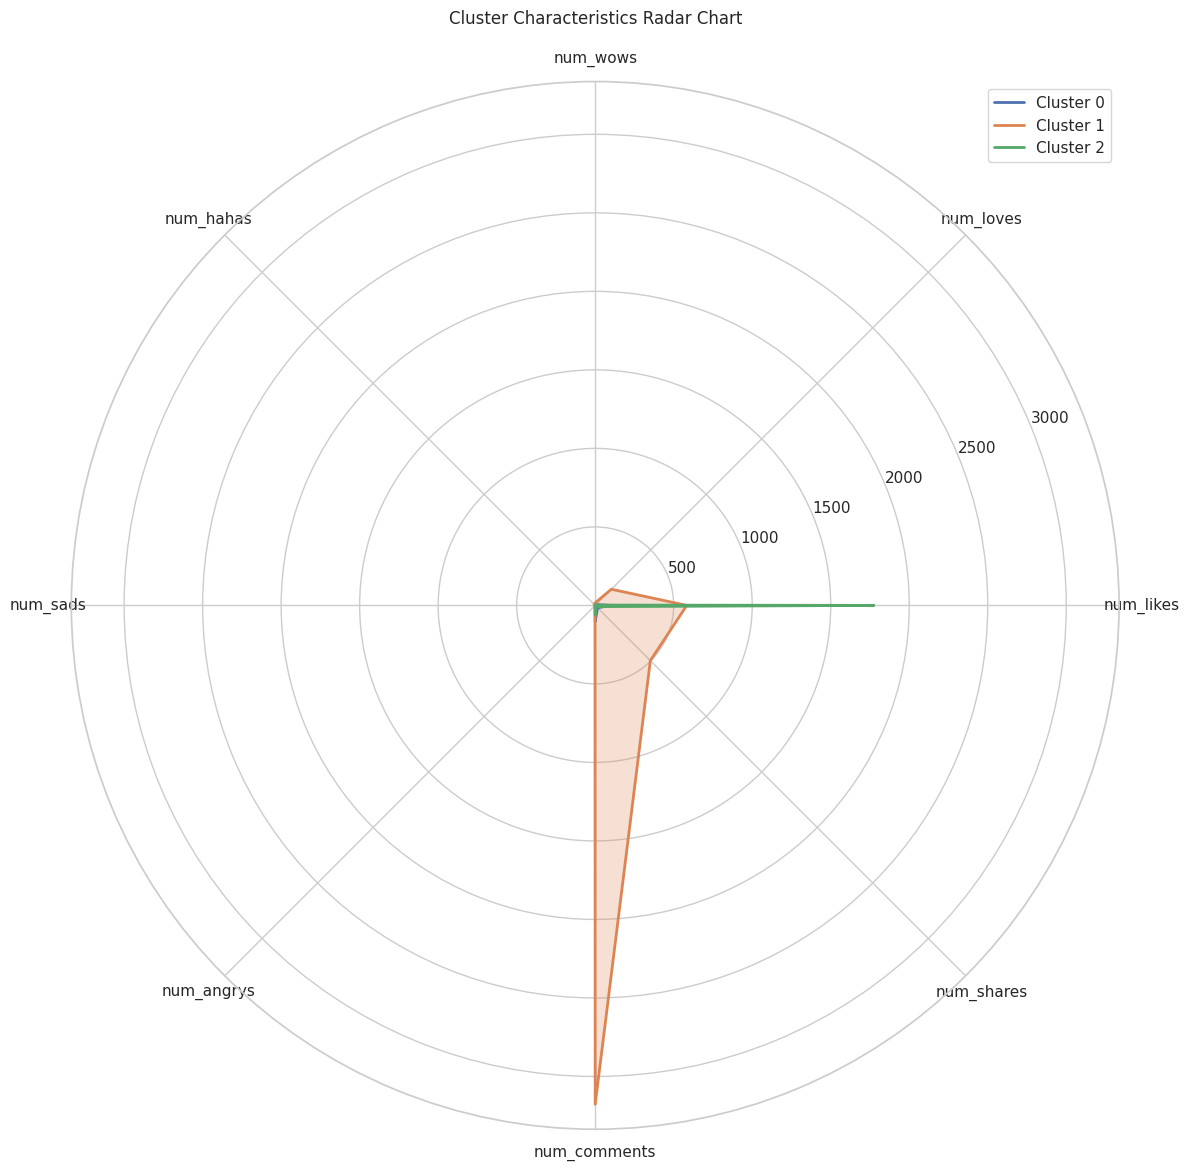

In [213]:
def plot_radar_chart(centroids, features, scaler=None):
    if scaler:
        # Ensure to apply inverse_transform only to the relevant part of the data
        centroids = scaler.inverse_transform(centroids[:, :len(features)])  # Adjust as per number of features
    
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    fig, ax = plt.subplots(figsize=(12,12), subplot_kw=dict(polar=True))
    
    for i, center in enumerate(centroids):
        values = center.tolist()
        values += values[:1]
        ax.plot(angles, values, label=f'Cluster {i}', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title('Cluster Characteristics Radar Chart', pad=20)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_radar_chart(kmeans.centroids, features, scaler)


# =====================================
# 8. COMBINED CLUSTER ANALYSIS FUNCTION
# =====================================

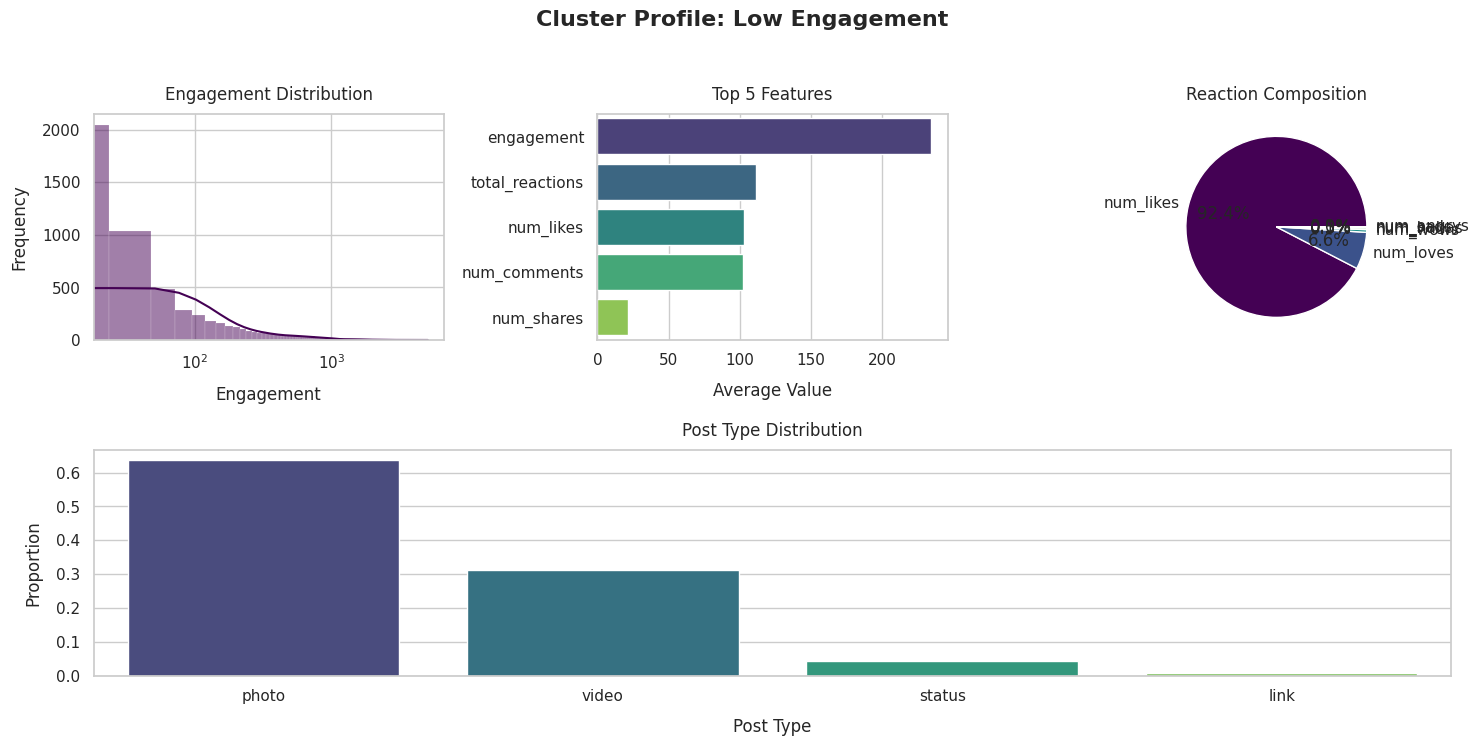


Statistics for Cluster Low Engagement:
Count: 6372 posts (90.4% of total)

                  count        mean         std  min   25%   50%    75%  \
num_likes        6372.0  102.672159  140.999093  0.0  15.0  44.0  135.0   
num_loves        6372.0    7.358914   19.725220  0.0   0.0   0.0    2.0   
num_wows         6372.0    0.537822    1.485232  0.0   0.0   0.0    0.0   
num_hahas        6372.0    0.338198    1.468883  0.0   0.0   0.0    0.0   
num_sads         6372.0    0.142185    0.948955  0.0   0.0   0.0    0.0   
num_angrys       6372.0    0.052260    0.330901  0.0   0.0   0.0    0.0   
num_comments     6372.0  101.991525  327.232350  0.0   0.0   3.0   15.0   
num_shares       6372.0   21.288606   62.845502  0.0   0.0   0.0    2.0   
total_reactions  6372.0  111.101538  148.004919  0.0  15.0  45.5  160.0   
engagement       6372.0  234.381670  437.107567  0.0  18.0  51.0  238.0   

                    max  
num_likes         924.0  
num_loves         220.0  
num_wows           2

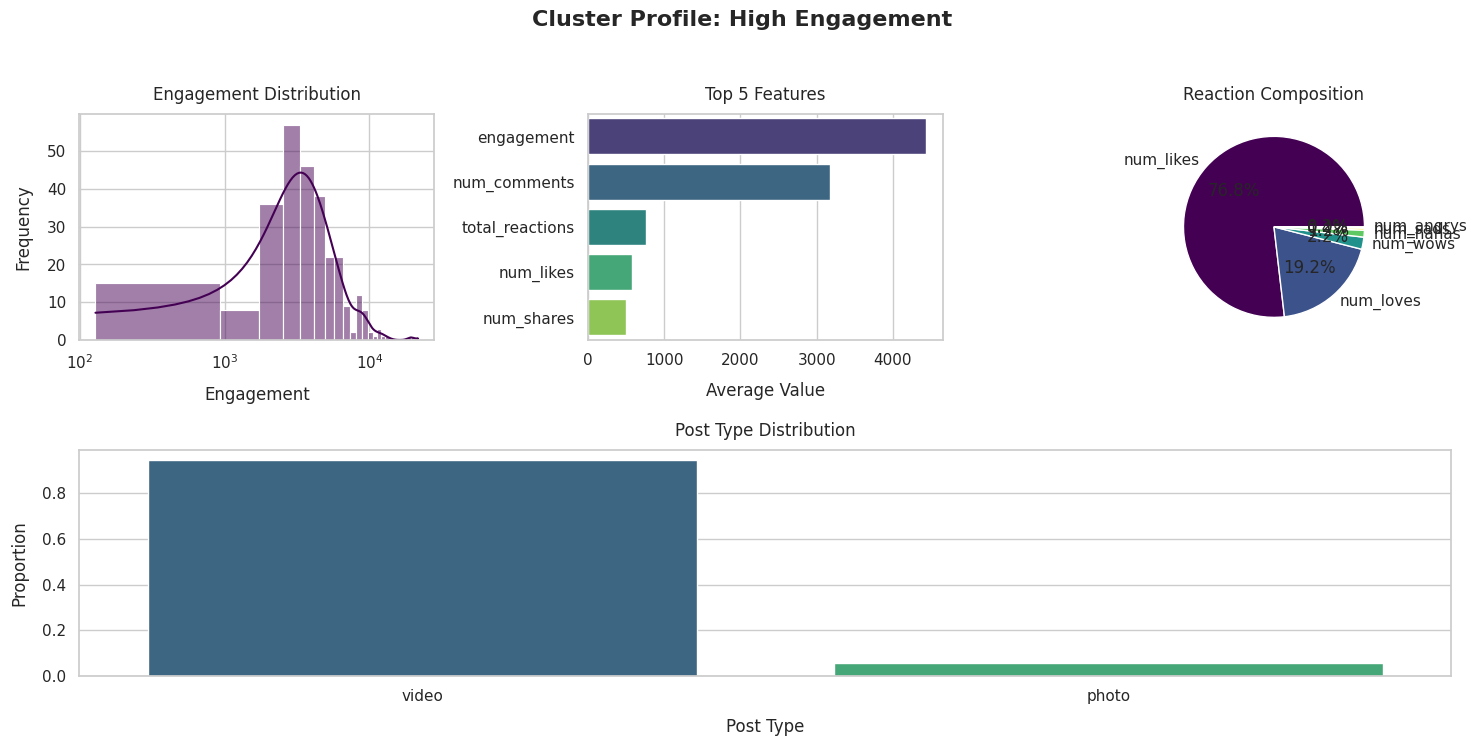


Statistics for Cluster High Engagement:
Count: 286 posts (4.1% of total)

                 count         mean          std    min      25%     50%  \
num_likes        286.0   583.290210   437.476836  106.0   230.00   363.5   
num_loves        286.0   145.555944   110.593845    0.0    62.25   125.0   
num_wows         286.0    16.416084    38.991834    0.0     2.00     4.0   
num_hahas        286.0     9.374126    16.102410    0.0     3.00     5.0   
num_sads         286.0     2.797203     6.004746    0.0     1.00     1.0   
num_angrys       286.0     1.618881     2.869964    0.0     0.00     1.0   
num_comments     286.0  3177.209790  2835.886788    3.0  1376.50  2169.0   
num_shares       286.0   496.881119   347.388977    0.0   290.00   451.5   
total_reactions  286.0   759.052448   547.145268  123.0   325.50   463.0   
engagement       286.0  4433.143357  2880.249783  128.0  2699.25  3818.0   

                     75%      max  
num_likes         979.50   1766.0  
num_loves       

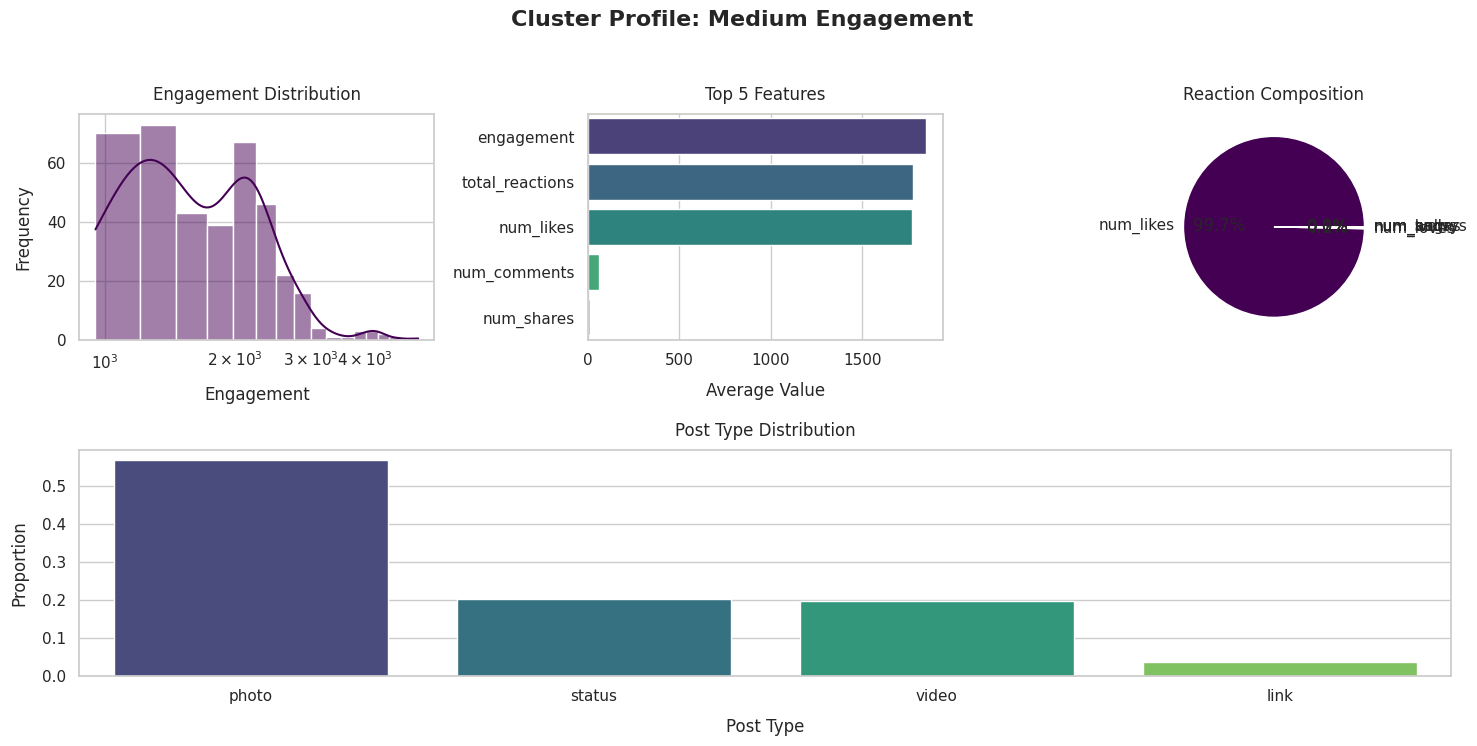


Statistics for Cluster Medium Engagement:
Count: 392 posts (5.6% of total)

                 count         mean         std    min      25%     50%  \
num_likes        392.0  1772.974490  663.604310  862.0  1225.75  1712.0   
num_loves        392.0     3.104592    9.115164    0.0     0.00     0.0   
num_wows         392.0     2.469388    6.972293    0.0     0.00     0.0   
num_hahas        392.0     0.188776    0.852303    0.0     0.00     0.0   
num_sads         392.0     0.030612    0.224079    0.0     0.00     0.0   
num_angrys       392.0     0.005102    0.071337    0.0     0.00     0.0   
num_comments     392.0    59.025510  111.319357    0.0    10.00    19.0   
num_shares       392.0    11.224490   26.132960    0.0     0.00     2.0   
total_reactions  392.0  1778.772959  665.816597  931.0  1229.75  1727.0   
engagement       392.0  1849.022959  695.029578  951.0  1278.50  1823.0   

                     75%     max  
num_likes        2187.00  4710.0  
num_loves           0.00   

In [214]:
def comprehensive_cluster_analysis(df, features, reaction_cols, cluster_col='cluster_label', show_plots=True, show_report=True):
    report = {}
    
    if show_plots:
        for cluster in df[cluster_col].unique():
            cluster_data = df[df[cluster_col] == cluster]
            fig = plt.figure(figsize=(15, 10))
            fig.suptitle(f'Cluster Profile: {cluster}', fontsize=16, y=1.02, fontweight='bold')
            
            # Engagement distribution
            ax1 = plt.subplot2grid((3, 3), (0, 0))
            sns.histplot(cluster_data['engagement'], kde=True, ax=ax1, color='#440154')
            ax1.set_title('Engagement Distribution', pad=10)
            ax1.set_xlabel('Engagement', labelpad=10)
            ax1.set_ylabel('Frequency', labelpad=10)
            ax1.set_xscale('log')
            
            # Top features
            ax2 = plt.subplot2grid((3, 3), (0, 1))
            top_features = cluster_data[features].mean().sort_values(ascending=False)[:5]
            sns.barplot(x=top_features.values, y=top_features.index, ax=ax2, palette='viridis')
            ax2.set_title('Top 5 Features', pad=10)
            ax2.set_xlabel('Average Value', labelpad=10)
            ax2.set_ylabel('')
            
            # Reaction composition
            ax3 = plt.subplot2grid((3, 3), (0, 2))
            reactions = cluster_data[reaction_cols].mean()
            reactions.plot.pie(autopct='%1.1f%%', ax=ax3, 
                              colors=['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725', '#f0f921'])
            ax3.set_title('Reaction Composition', pad=10)
            ax3.set_ylabel('')
            
            # Post type distribution
            ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
            post_types = cluster_data['status_type'].value_counts(normalize=True)
            sns.barplot(x=post_types.index, y=post_types.values, ax=ax4, palette='viridis')
            ax4.set_title('Post Type Distribution', pad=10)
            ax4.set_xlabel('Post Type', labelpad=10)
            ax4.set_ylabel('Proportion', labelpad=10)
            plt.tight_layout()
            plt.show()
            
            # Print statistics after the plot
            count = len(cluster_data)
            cluster_stats = cluster_data[features].describe().T  # Statistics for all features in that cluster
            
            print(f"\nStatistics for Cluster {cluster}:")
            print(f"Count: {count} posts ({count / len(df) * 100:.1f}% of total)\n")
            print(cluster_stats)
            
            # Comparison to overall averages
            overall_means = df[features].mean()
            comparison = (cluster_stats['mean'] / overall_means - 1) * 100
            print('\n')
            print("\n" + "-"*50 + "\n")
            print(f"COMPARISON TO OVERALL AVERAGES:\n")
            print(f"Cluster {cluster} vs overall average (% difference):")
            print(comparison.round(1).astype(str) + "%")
            print("\n" + "-"*50 + "\n")
    
    for cluster in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster][features]
        
        cluster_stats = {
            'count': len(cluster_data),
            'mean': cluster_data.mean().to_dict(),
            'median': cluster_data.median().to_dict(),
            'std': cluster_data.std().to_dict(),
            'min': cluster_data.min().to_dict(),
            'max': cluster_data.max().to_dict()
        }
        
        report[cluster] = cluster_stats
    
features_for_analysis = reaction_cols + ['num_comments', 'num_shares', 'total_reactions', 'engagement']
cluster_report = comprehensive_cluster_analysis(
    df=df,
    features=features_for_analysis,
    reaction_cols=reaction_cols,
    cluster_col='cluster_label',
    show_plots=True,
    show_report=True
)
